Connected to anaconda3 (Python 3.11.11)

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

In [ ]:
# Load image and annotation example
img_path = 'Benign/image/1.jpg'
json_path = 'Benign/segmentation/liver/1.json'

image = Image.open(img_path).convert('RGB')

In [ ]:
with open(json_path) as f:
    annotations = json.load(f)
    
# Extract coordinates from JSON
polygon = [(point[0], point[1]) for point in annotations]

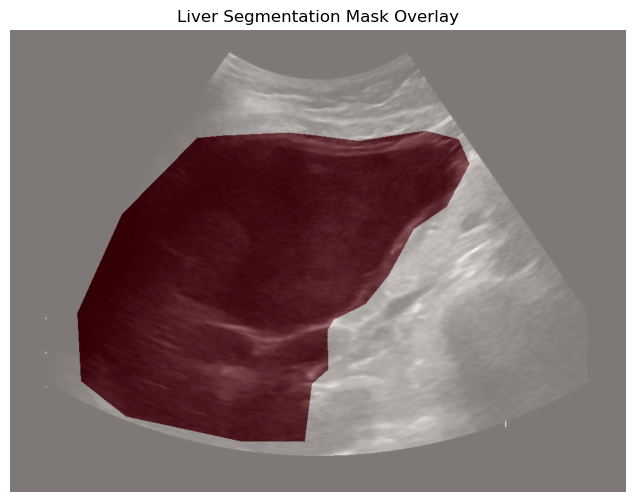

In [ ]:
# Create mask
mask = Image.new('L', image.size, 0)
ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
mask = np.array(mask)

# Display image with mask
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.title('Liver Segmentation Mask Overlay')
plt.axis('off')
plt.show()

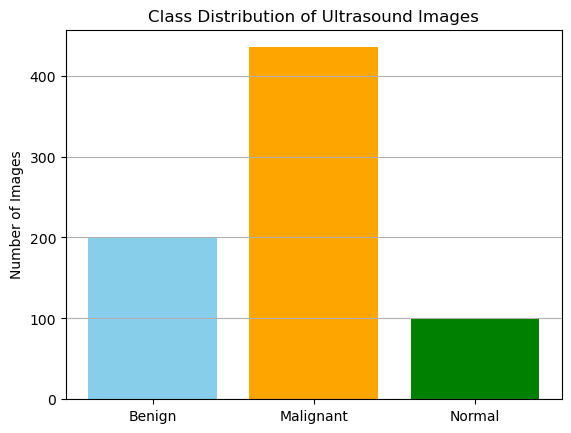

In [ ]:
# Class distribution visualization
import matplotlib.pyplot as plt

labels = ['Benign', 'Malignant', 'Normal']
counts = [200, 435, 100]  # example counts from your provided data

plt.bar(labels, counts, color=['skyblue', 'orange', 'green'])
plt.title('Class Distribution of Ultrasound Images')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()

Loaded 200 images from category: Benign
Loaded 435 images from category: Malignant
Loaded 100 images from category: Normal


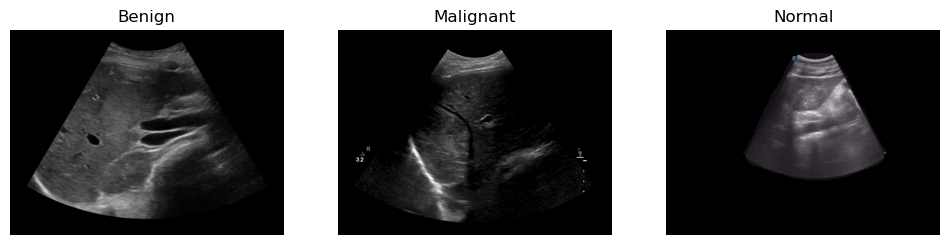

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define root path
# data_root = 'path/to/dataset_root'  # replace this with your actual dataset root path

# Categories in the dataset
categories = ['Benign', 'Malignant', 'Normal']

# Load images into dictionary
images_dict = {}

for category in categories:
    image_folder = os.path.join(category, 'image')
    images = []

    # List all files in the image folder
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            img = Image.open(image_path).convert('RGB')
            images.append(img)
    
    images_dict[category] = images
    print(f"Loaded {len(images)} images from category: {category}")

# Example to visualize first image from each category
plt.figure(figsize=(12, 4))
for idx, category in enumerate(categories):
    plt.subplot(1, 3, idx+1)
    plt.imshow(images_dict[category][0])
    plt.title(category)
    plt.axis('off')

plt.show()

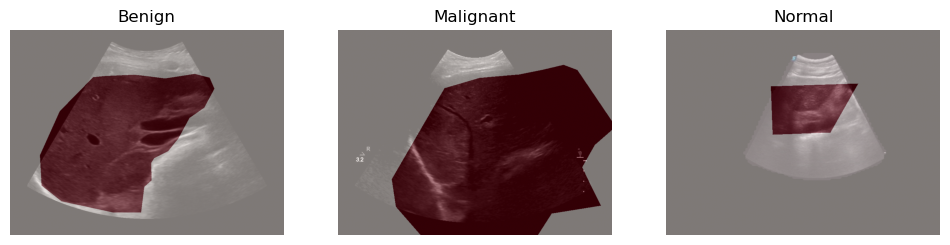

In [ ]:
# Also visualize the first image from each category with its mask
plt.figure(figsize=(12, 4))
for idx, category in enumerate(categories):
    plt.subplot(1, 3, idx+1)
    img = images_dict[category][0]
    plt.imshow(img)
    
    # Load corresponding mask
    mask_path = os.path.join(category, 'segmentation/liver', '1.json')  # Adjust as needed
    with open(mask_path) as f:
        annotations = json.load(f)
    
    # Extract coordinates from JSON
    polygon = [(point[0], point[1]) for point in annotations]
    
    # Create mask
    mask = Image.new('L', img.size, 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    mask = np.array(mask)
    
    plt.imshow(mask, alpha=0.5, cmap='Reds')
    plt.title(category)
    plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

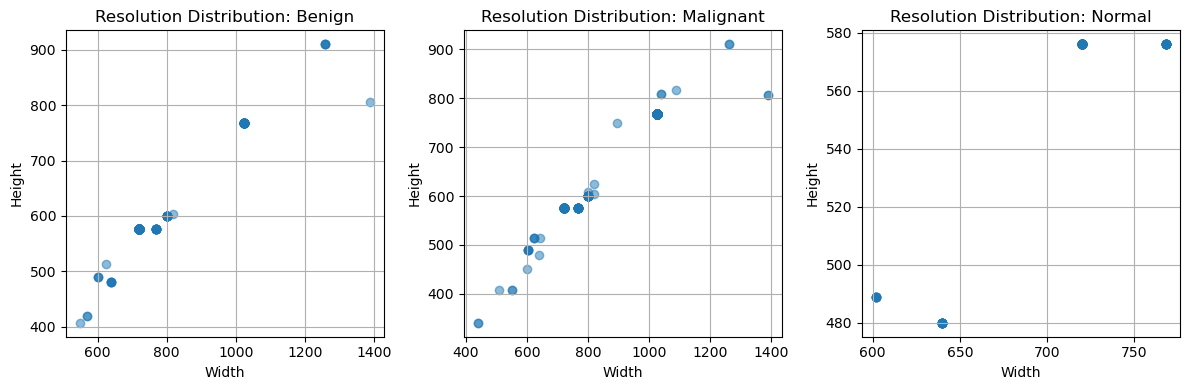

In [ ]:
# Inspect resolution distribution and random samples
resolutions = {'Benign': [], 'Malignant': [], 'Normal': []}

for category, imgs in images_dict.items():
    for img in imgs:
        resolutions[category].append(img.size)  # (width, height)

# Plot resolution distributions
plt.figure(figsize=(12, 4))
for idx, (category, res_list) in enumerate(resolutions.items()):
    widths, heights = zip(*res_list)
    plt.subplot(1, 3, idx + 1)
    plt.scatter(widths, heights, alpha=0.5)
    plt.title(f'Resolution Distribution: {category}')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)

plt.tight_layout()
plt.show()

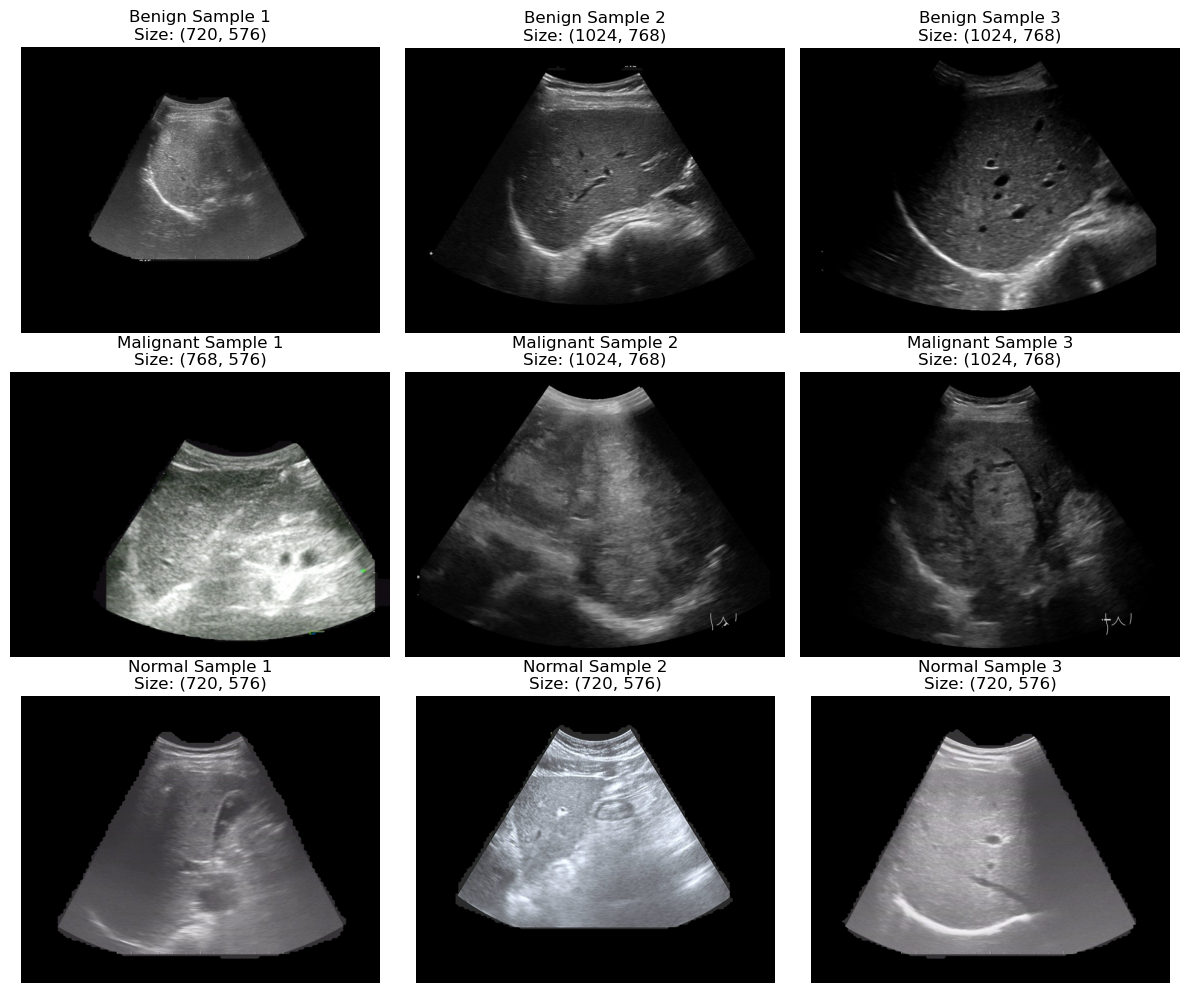

In [ ]:
# Visualize random samples from each category
num_samples = 3
plt.figure(figsize=(12, 10))
for idx, category in enumerate(images_dict):
    sample_images = random.sample(images_dict[category], num_samples)
    for jdx, img in enumerate(sample_images):
        plt.subplot(len(categories), num_samples, idx*num_samples + jdx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{category} Sample {jdx+1}\nSize: {img.size}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Define the target size
TARGET_SIZE = (224, 224)

# Enhanced preprocessing function
def preprocess_image(image):
    # Resize image
    image = image.resize(TARGET_SIZE)

    # Convert to grayscale for CLAHE
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(gray)

    # Normalize to [0,1]
    normalized_img = clahe_img / 255.0

    # Expand dimensions to match model input [channels, height, width]
    return np.expand_dims(normalized_img, axis=0)

In [ ]:
# Apply preprocessing to all images
preprocessed_images = {}
for category, imgs in images_dict.items():
    preprocessed_images[category] = [preprocess_image(img) for img in imgs]
    print(f"Preprocessed {len(imgs)} images from category: {category}")

Preprocessed 200 images from category: Benign
Preprocessed 435 images from category: Malignant
Preprocessed 100 images from category: Normal


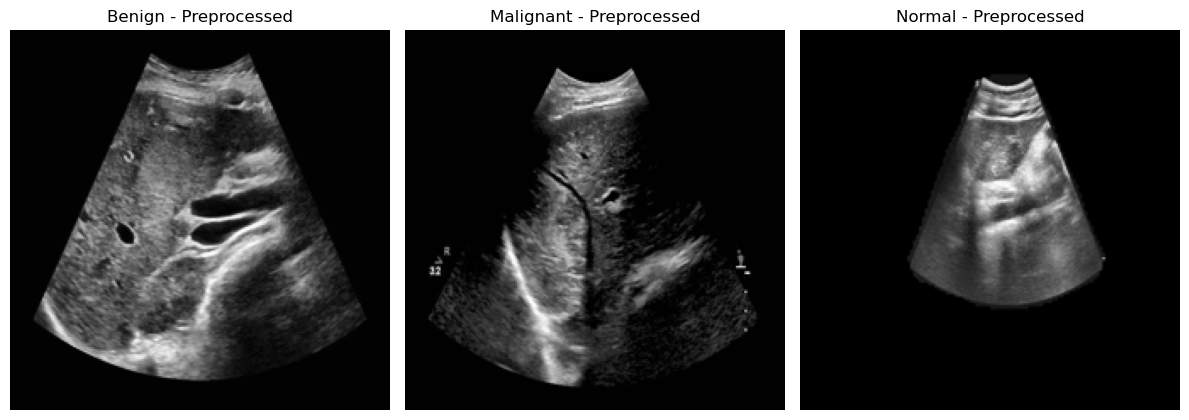

In [ ]:
# Visualize the results for verification
plt.figure(figsize=(12, 6))
for idx, category in enumerate(categories):
    # Display first processed image from each category
    plt.subplot(1, 3, idx+1)
    img = preprocessed_images[category][0].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"{category} - Preprocessed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class LiverUltrasoundDataset(Dataset):
    def __init__(self, images_dict, categories):
        self.images = []
        self.labels = []
        self.cat2idx = {cat: i for i, cat in enumerate(categories)}
        for cat, imgs in images_dict.items():
            self.images.extend(imgs)
            self.labels.extend([self.cat2idx[cat]] * len(imgs))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

In [ ]:
# Instantiate dataset and dataloader
categories = ['Benign', 'Malignant', 'Normal']
dataset = LiverUltrasoundDataset(preprocessed_images, categories)

# Train-validation split
from sklearn.model_selection import train_test_split
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.labels[i] for i in indices])

from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load VGG16 pretrained
vgg16 = models.vgg16(pretrained=True)
# Adapt for grayscale if needed:
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # For single-channel input

# Replace classifier head
vgg16.classifier[6] = nn.Linear(4096, 3)

# Freeze initial layers for transfer learning
for param in vgg16.features.parameters():
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
vgg16 = vgg16.to(device)

/Users/hxw/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hxw/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}")

Epoch 1/10, Loss: 0.9251
Epoch 2/10, Loss: 0.8082
Epoch 3/10, Loss: 0.7377
Epoch 4/10, Loss: 0.7358
Epoch 5/10, Loss: 0.6750
Epoch 6/10, Loss: 0.6531
Epoch 7/10, Loss: 0.6134
Epoch 8/10, Loss: 0.5763
Epoch 9/10, Loss: 0.5363
Epoch 10/10, Loss: 0.5198


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

vgg16.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vgg16(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=categories))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

      Benign       0.47      0.78      0.58        40
   Malignant       0.95      0.64      0.77        87
      Normal       0.64      0.70      0.67        20

    accuracy                           0.69       147
   macro avg       0.69      0.71      0.67       147
weighted avg       0.78      0.69      0.70       147

[[31  3  6]
 [29 56  2]
 [ 6  0 14]]


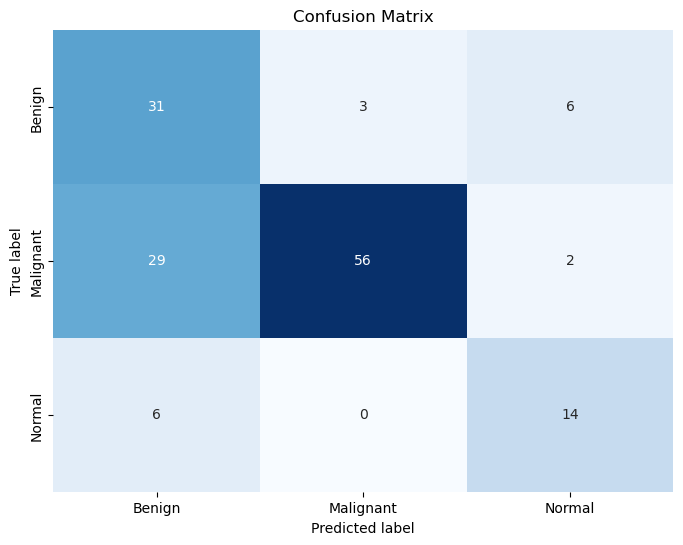

In [ ]:
# Visualize the training results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, categories)

In [ ]:
from monai.networks.nets import DenseNet121
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Med3D for 2D data: use DenseNet121 (spatial_dims=2)
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,       # Your images are grayscale after preprocessing
    out_channels=3,      # Three classes: Benign, Malignant, Normal
    pretrained=True      # Loads ImageNet weights, or see below for Med3D weights
)
model = model.to(device)

# Optionally, load Med3D weights if you have them:
# model.load_state_dict(torch.load("path_to_med3d_pretrained_weights.pth"))

# Print model architecture
print(model)

2025-05-16 17:59:04.393806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/hxw/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 29.0MB/s]


DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [ ]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    return val_loss / len(val_loader.dataset)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training step
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation step
    avg_val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
model.load_state_dict(best_model_state)

Epoch 1/30, Train Loss: 0.1178, Val Loss: 1.0186
Epoch 2/30, Train Loss: 0.0716, Val Loss: 0.6695
Epoch 3/30, Train Loss: 0.0338, Val Loss: 0.7830
Epoch 4/30, Train Loss: 0.0820, Val Loss: 1.0805
Epoch 5/30, Train Loss: 0.0375, Val Loss: 0.8821
Epoch 6/30, Train Loss: 0.0473, Val Loss: 0.6707
Epoch 7/30, Train Loss: 0.0292, Val Loss: 0.7620
Early stopping triggered.


<All keys matched successfully>

              precision    recall  f1-score   support

      Benign       0.84      0.40      0.54        40
   Malignant       0.81      0.94      0.87        87
      Normal       0.59      0.80      0.68        20

    accuracy                           0.78       147
   macro avg       0.75      0.71      0.70       147
weighted avg       0.79      0.78      0.76       147

[[16 17  7]
 [ 1 82  4]
 [ 2  2 16]]


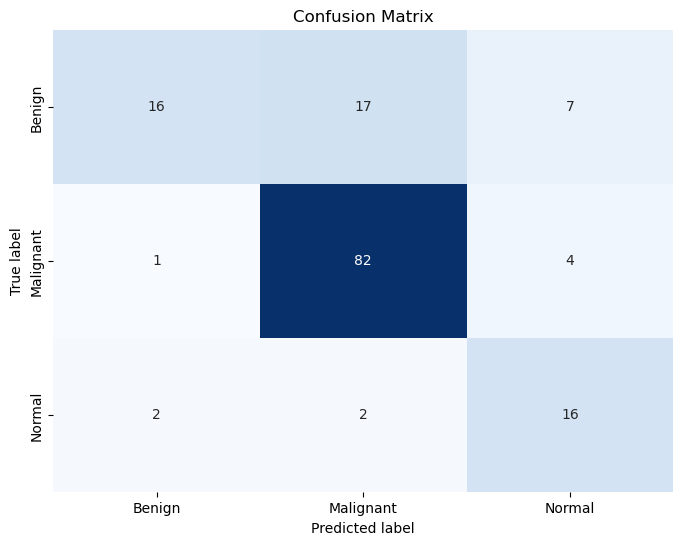

In [ ]:
# Evaluate the model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=categories))
print(confusion_matrix(all_labels, all_preds))
# Visualize the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, categories)